# Problem 1. American Handwriting

# Part 1: Derivative

*f*(x)$_i$ = $\frac{e_i^x}{\sum_je_j^x}$ 

gradient = $\begin{cases} f(x)_i(1-f(x)_i) & j = i\\-f(x)_if(x)_j & j\ne i \end{cases}$

In [2]:
import math
import numpy as np
# help from: https://slowbreathing.github.io/articles/2019-05/softmax-and-its-gradient
def softmax(vector):
  ''' Takes a vector (np.array) and returns softmax matrix '''
  result = []
  for row in vector:
    vals = np.asarray(row)
    result.append(np.exp(vals)/float(sum(np.exp(vals))))

  return np.array(result)

def softmax_gradient(vector):
  ''' 
  Takes a softmax vector (np.array) and returns the softmax gradient matrix 
  '''
  diag = np.asarray(np.diag(vector))
  size = len(diag)
  matrix = np.empty((size, size), dtype=float)
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      if i == j:
        matrix[i][j] = vector[i] * (1-vector[i])
      else:
        matrix[i][j] = -vector[i]*vector[j]
  return matrix

In [104]:
# Test run of softmax and gradient
x = np.array([[1,3,5,7]])
sm = softmax(x)
print(sm[0])
sm_grad = softmax_gradient(sm[0])
print()
print(sm_grad)
print(np.diag(sm_grad))

[0.00214401 0.0158422  0.11705891 0.86495488]

[[ 2.13941201e-03 -3.39658185e-05 -2.50975338e-04 -1.85447085e-03]
 [-3.39658185e-05  1.55912258e-02 -1.85447085e-03 -1.37027892e-02]
 [-2.50975338e-04 -1.85447085e-03  1.03356124e-01 -1.01250678e-01]
 [-1.85447085e-03 -1.37027892e-02 -1.01250678e-01  1.16807938e-01]]
[0.00213941 0.01559123 0.10335612 0.11680794]


# Part 2: Simple

Below is the code for the neural network structure.

In [88]:
# help from: https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

class Layer:
  def __init__(self, activ_function, activ_prime_function, in_size, out_size):
    '''
    Takes as parameters:
      activ_function: activation function
      activ_prime_function: the gradient of activation function
      in_size: input size
      out_size: output size
    Opting for a more complex layer class than found in link to keep together.
    '''
    self.input = None
    self.input_adjusted = None # used for holding adjusted input
    self.output = None
    self.activ = activ_function
    self.activ_prime = activ_prime_function
    self.weights = np.random.rand(in_size, out_size) - 0.5
    self.bias = np.random.rand(1, out_size) - 0.5

  def forward_prop(self, input_data):
    '''
    Takes input_data as a parameter, sets self.output as:
      activation of dot product of input_data and weights + bias
    Returns self.output.
    '''
    self.input = input_data
    self.input_adjusted = np.dot(self.input, self.weights) + self.bias
    self.output = self.activ(self.input_adjusted)
    return self.output   

  def back_prop(self, out_err, learn_rate):
    '''
    Takes as parameters:
      out_err: a given output error
      learn_rate: a given learning rate
    Returns:
      input error from element-wise multiplication of matrices (hidden layer)
    '''
    adjusted_err = self.activ_prime(self.input_adjusted[0]) * out_err

    in_err = np.dot(adjusted_err, self.weights.T)
    weight_err = np.dot(self.input.T, adjusted_err)
    self.weights -= learn_rate * weight_err
    self.bias -= learn_rate * adjusted_err
    return in_err

class NeuralNet:
  def __init__(self):
    self.layers = []
    self.loss = None
    self.loss_prime = None
    self.err = []
  
  def add_layer(self, layer):
    self.layers.append(layer)

  def set_loss(self, loss, loss_prime):
    self.loss = loss
    self.loss_prime = loss_prime
  
  def predict(self, input_data):
    '''
    Returns predicted output for elements in input_data.
    '''
    result = []
    
    for element in input_data:
      for layer in self.layers:
        element = layer.forward_prop(element)
      result.append(element)
    
    return result

  def fit(self, x_train, y_train, iterations, learn_rate):
    tot_count = len(x_train)
    for i in range(iterations):
      err = 0
      for j in range(tot_count):
        # train NN
        x = x_train[j]
        for layer in self.layers:
          x = layer.forward_prop(x)

        y = y_train[j]
        pred_err = self.loss_prime(y, x)
        for layer in reversed(self.layers):
          pred_err = layer.back_prop(pred_err, learn_rate)
        
        # compute loss to store
        err += self.loss(y, x)
      err /= tot_count
      self.err.append(err)

In [89]:
# sigmoid functions
def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoid_prime(x):
  return sigmoid(x) * (1 - sigmoid(x))

# L2 error functions
def mse(x, x_pred):
  return np.mean((np.power(x-x_pred, 2)))

def mse_prime(x, x_pred):
  return 2*(x_pred-x)/x.size;

In [90]:
# Test run of NN for debugging and validation
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

nn = NeuralNet()
nn.add_layer(Layer(tanh, tanh_prime, 2, 3))
nn.add_layer(Layer(tanh, tanh_prime, 3, 1))

nn.set_loss(mse, mse_prime)
nn.fit(x_train, y_train, 1000, 0.1)

print(nn.err[-1])

0.27885064317061253


In [19]:
from keras.datasets import mnist
from keras.utils import np_utils

(trainX, train_y), (testX, testy) = mnist.load_data()

time: 434 ms (started: 2022-11-07 03:43:25 +00:00)


In [20]:
# reshape and normalize input data, copied from earlier mentioned article
train_X = trainX.reshape(trainX.shape[0], 1, 784)
train_X = train_X.astype('float32')
train_X /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
train_y = np_utils.to_categorical(train_y)

# same for test data : 10000 samples
test_X = testX.reshape(testX.shape[0], 1, 784)
test_X = test_X.astype('float32')
test_X /= 255
test_y = np_utils.to_categorical(testy)

# end of copied normalization

time: 229 ms (started: 2022-11-07 03:43:29 +00:00)


In [144]:
nn_mnist = NeuralNet()
input_layer = Layer(sigmoid, sigmoid_prime, 784, 128)
output_layer = Layer(softmax, sigmoid_prime, 128, 10)
nn_mnist.add_layer(input_layer)
nn_mnist.add_layer(output_layer)
nn_mnist.set_loss(mse, mse_prime)
# I am using much smaller chunks of the train data because my scratch NN is slow
nn_mnist.fit(train_X[0:1000], train_y[0:1000], 30, 0.002)

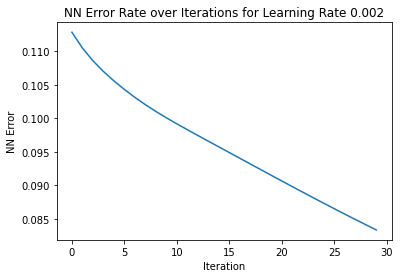

In [146]:
import matplotlib.pyplot as plt

plt.plot(range(30),nn_mnist.err)
plt.ylabel('NN Error')
plt.xlabel('Iteration')
plt.title('NN Error Rate over Iterations for Learning Rate 0.002')
plt.show()

In [147]:
nn_mnist2 = NeuralNet()
nn_mnist2.add_layer(input_layer)
nn_mnist2.add_layer(output_layer)
nn_mnist2.set_loss(mse, mse_prime)
nn_mnist2.fit(train_X[0:1000], train_y[0:1000], 30, 0.02)

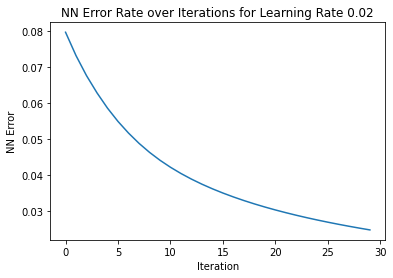

In [148]:
plt.plot(range(30),nn_mnist2.err)
plt.ylabel('NN Error')
plt.xlabel('Iteration')
plt.title('NN Error Rate over Iterations for Learning Rate 0.02')
plt.show()

In [149]:
nn_mnist3 = NeuralNet()
nn_mnist3.add_layer(input_layer)
nn_mnist3.add_layer(output_layer)
nn_mnist3.set_loss(mse, mse_prime)
nn_mnist3.fit(train_X[0:1000], train_y[0:1000], 30, 0.2)

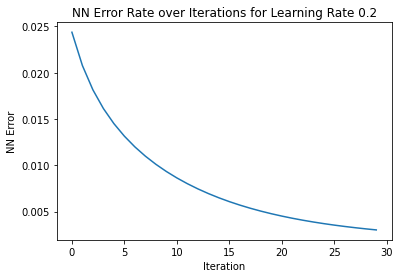

In [150]:
plt.plot(range(30),nn_mnist3.err)
plt.ylabel('NN Error')
plt.xlabel('Iteration')
plt.title('NN Error Rate over Iterations for Learning Rate 0.2')
plt.show()

The network's error decreases at higher learning rates with fixed iterations.

In [151]:
nn_mnist4 = NeuralNet()
nn_mnist4.add_layer(input_layer)
nn_mnist4.add_layer(output_layer)
nn_mnist4.set_loss(mse, mse_prime)
nn_mnist4.fit(train_X[0:1000], train_y[0:1000], 50, 0.2)
nn_mnist5 = NeuralNet()
nn_mnist5.add_layer(input_layer)
nn_mnist5.add_layer(output_layer)
nn_mnist5.set_loss(mse, mse_prime)
nn_mnist5.fit(train_X[0:1000], train_y[0:1000], 70, 0.2)
nn_mnist6 = NeuralNet()
nn_mnist6.add_layer(input_layer)
nn_mnist6.add_layer(output_layer)
nn_mnist6.set_loss(mse, mse_prime)
nn_mnist6.fit(train_X[0:1000], train_y[0:1000], 90, 0.2)

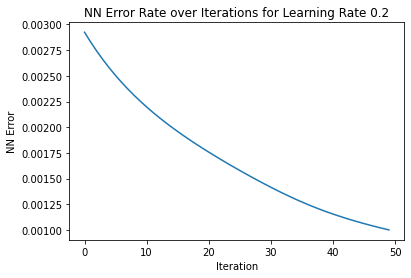

In [152]:
plt.plot(range(50),nn_mnist4.err)
plt.ylabel('NN Error')
plt.xlabel('Iteration')
plt.title('NN Error Rate over Iterations for Learning Rate 0.2')
plt.show()

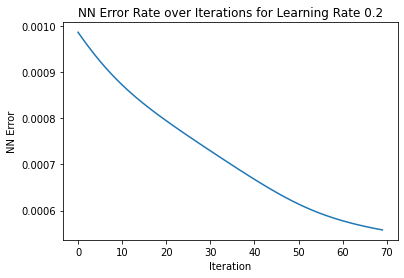

In [153]:
plt.plot(range(70),nn_mnist5.err)
plt.ylabel('NN Error')
plt.xlabel('Iteration')
plt.title('NN Error Rate over Iterations for Learning Rate 0.2')
plt.show()

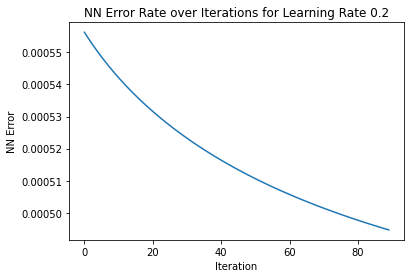

In [154]:
plt.plot(range(90),nn_mnist6.err)
plt.ylabel('NN Error')
plt.xlabel('Iteration')
plt.title('NN Error Rate over Iterations for Learning Rate 0.2')
plt.show()

Likewise, the error decreases with more iterations.

In [157]:
def nn_test_score(pred, actual):
  samples = len(pred)
  total_right = 0
  for i in range(samples):
    if np.argmax(pred[i]) == np.argmax(actual[i]):
      total_right += 1
  
  return total_right/samples

In [161]:
# increase learning rate
pred1 = nn_mnist.predict(test_X)
pred2 = nn_mnist2.predict(test_X)
pred3 = nn_mnist3.predict(test_X)
# increase iterations
pred4 = nn_mnist4.predict(test_X)
pred5 = nn_mnist5.predict(test_X)
pred6 = nn_mnist6.predict(test_X)

learn_acc = []
for prediction in [pred1,pred2,pred3]:
  learn_acc.append(nn_test_score(prediction, test_y))

iter_acc = []
for prediction in [pred3,pred4,pred5,pred6]:
  iter_acc.append(nn_test_score(prediction, test_y))

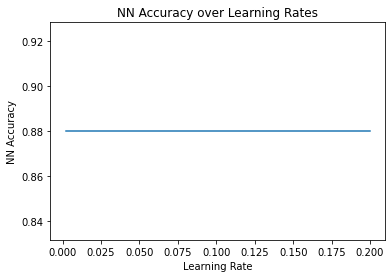

In [160]:
plt.plot([0.002,0.02,0.2],learn_acc)
plt.ylabel('NN Accuracy')
plt.xlabel('Learning Rate')
plt.title('NN Accuracy over Learning Rates')
plt.show()

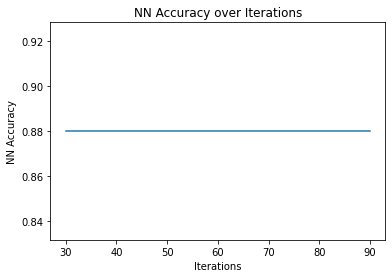

In [162]:
plt.plot([30,50,70,90],iter_acc)
plt.ylabel('NN Accuracy')
plt.xlabel('Iterations')
plt.title('NN Accuracy over Iterations')
plt.show()

It appears I had a consistent 88% test accuracy for all variation in learning rates/iterations.

# Part 3: Keras

In [5]:
# help from: https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5
# and from: https://github.com/soumyac1999/keras-mnist-nn/blob/master/mnist_keras.py
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten 

nn_kera = Sequential()
nn_kera.add(Flatten(input_shape=(1,784)))
nn_kera.add(Dense(128, activation='sigmoid'))
nn_kera.add(Dense(10, activation='softmax'))
nn_kera.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 545 µs (started: 2022-11-07 03:23:44 +00:00)


In [7]:
nn_kera.fit(train_X, train_y, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 4s 7ms/step - loss: 0.6158 - accuracy: 0.8542
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2786 - accuracy: 0.9224
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 0.2219 - accuracy: 0.9379
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1865 - accuracy: 0.9473
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1606 - accuracy: 0.9546
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1398 - accuracy: 0.9606
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1236 - accuracy: 0.9650
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - loss: 0.1094 - accuracy: 0.9690
Epoch 9/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0975 - accuracy: 0.9729
Epoch 10/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0875 - accuracy: 0.9757

time: 1min 17s (started: 2022-11-07 03:23:44 +00:00)


In [176]:
new_nn = NeuralNet()
new_nn.add_layer(input_layer)
new_nn.add_layer(output_layer)
new_nn.set_loss(mse, mse_prime)

In [180]:
new_nn.fit(train_X, train_y, 30, 0.2)

KeyboardInterrupt: ignored

time: 44min 24s (started: 2022-11-07 01:12:53 +00:00)


In [ ]:
# after 44 min, decided to restart with smaller chunk

In [181]:
new_nn = NeuralNet()
new_nn.add_layer(input_layer)
new_nn.add_layer(output_layer)
new_nn.set_loss(mse, mse_prime)
new_nn.fit(train_X[0:2000], train_y[0:2000], 30, 0.2)

time: 3min 36s (started: 2022-11-07 01:58:31 +00:00)


In [182]:
print('Scratch NN, final loss: ', new_nn.err[-1])
pred = new_nn.predict(test_X)
score = nn_test_score(pred, test_y)
print('Scratch NN, final test accuracy: ', score)

Scratch NN, final loss:  0.0008242009704422527
Scratch NN, final test accuracy:  0.9646
time: 984 ms (started: 2022-11-07 02:02:15 +00:00)


As you can see above, the keras NN is both much faster and a better predictor than mine.

# Part 4: ReLU

In [8]:
nn_kera2 = Sequential()
nn_kera2.add(Flatten(input_shape=(1,784)))
nn_kera2.add(Dense(128, activation='relu'))
nn_kera2.add(Dense(10, activation='softmax'))
nn_kera2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 43.8 ms (started: 2022-11-07 03:25:02 +00:00)


In [9]:
output = nn_kera2.fit(train_X, train_y, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 4s 7ms/step - loss: 0.3603 - accuracy: 0.9016
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1680 - accuracy: 0.9529
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1201 - accuracy: 0.9658
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0932 - accuracy: 0.9734
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0750 - accuracy: 0.9786
Epoch 6/30
469/469 [==============================] - 4s 7ms/step - loss: 0.0629 - accuracy: 0.9818
Epoch 7/30
469/469 [==============================] - 4s 7ms/step - loss: 0.0514 - accuracy: 0.9851
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0430 - accuracy: 0.9885
Epoch 9/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0369 - accuracy: 0.9895
Epoch 10/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0310 - accuracy: 0.9916

Using ReLU both saw better loss and accuracy (~0.01, ~0.998 vs ~0.001, ~0.999).




# Part 5: Dropout

In [10]:
from keras.layers import Dropout
from keras import regularizers

best_score = 0
best_drop = 0
best_reg = 0
# pulling regularization rates from: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/#:~:text=Keras%20provides%20a%20weight%20regularization%20API%20that%20allows,absolute%20weights.%20L2%3A%20Sum%20of%20the%20squared%20weights.
for reg in [0.0001,0.001,0.01,0.1]:
  for droprate in [0.1,0.2,0.5]:
    nn_kera3 = Sequential()
    nn_kera3.add(Flatten(input_shape=(1,784)))
    nn_kera3.add(Dense(128, activation='relu', 
                       kernel_regularizer=regularizers.L2(reg)))
    nn_kera3.add(Dropout(droprate))
    nn_kera3.add(Dense(100, activation='relu', 
                       kernel_regularizer=regularizers.L2(reg)))
    nn_kera3.add(Dropout(droprate))
    nn_kera3.add(Dense(64, activation='relu', 
                       kernel_regularizer=regularizers.L2(reg)))
    nn_kera3.add(Dropout(droprate))
    nn_kera3.add(Dense(10, activation='softmax', 
                       kernel_regularizer=regularizers.L2(reg)))
    nn_kera3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # dropping epochs to speed up these loops
    nn_kera3.fit(train_X, train_y, epochs=10, batch_size=128, verbose=0)
    score = nn_kera3.evaluate(test_X, test_y, verbose=0)
    if score[1] > best_score: # test accuracy
      best_score = score[1]
      best_drop = droprate
      best_reg = reg

time: 6min (started: 2022-11-07 03:27:10 +00:00)


In [195]:
print("Best regularization hyperparam: {}; best droprate hyperparam: {}".format(
    best_reg, best_drop))
print("Score with these hyperparam: {}".format(best_score))

Best regularization hyperparam: 0.0001; best droprate hyperparam: 0.1
Score with these hyperparam: 0.9800999760627747
time: 2.15 ms (started: 2022-11-07 02:31:44 +00:00)


# Part 6: Convolution

I am fairly lost on this one, I attempted to make the network though!

In [28]:
from keras.layers import Conv2D, MaxPooling2D
# help from: https://www.tutorialspoint.com/keras/keras_convolution_neural_network.htm
# and from: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

# reshape data
ctrain_X = train_X.reshape(60000,28,28,1)
ctest_X = test_X.reshape(10000,28,28,1)

nn_kera4 = Sequential()
# use the same best_reg hyperparam found above
nn_kera4.add(Conv2D(64, kernel_size=(3,3), activation='relu',
                    input_shape=(28,28,1),
                    kernel_regularizer=regularizers.L2(best_reg)))
nn_kera4.add(MaxPooling2D((2,2)))
nn_kera4.add(Flatten())
# use the same best_drop hyperparam found above
nn_kera4.add(Dropout(best_drop))
nn_kera4.add(Dense(128, activation='relu',
                   kernel_regularizer=regularizers.L2(best_reg)))
nn_kera4.add(Dropout(best_drop))
nn_kera4.add(Dense(10, activation='softmax',
                   kernel_regularizer=regularizers.L2(best_reg)))
nn_kera4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 89.8 ms (started: 2022-11-07 04:46:58 +00:00)


In [31]:
nn_kera4.fit(ctrain_X, train_y, epochs=3, batch_size=128)
score = nn_kera4.evaluate(test_X, test_y, verbose=0)
print('Convolutional network test score: ', score[1])

Epoch 1/3
469/469 [==============================] - 59s 125ms/step - loss: 0.1413 - accuracy: 0.9719
Epoch 2/3
469/469 [==============================] - 59s 126ms/step - loss: 0.1220 - accuracy: 0.9782
Epoch 3/3
469/469 [==============================] - 60s 127ms/step - loss: 0.1103 - accuracy: 0.9817


ValueError: ignored

time: 3min 22s (started: 2022-11-07 04:47:53 +00:00)


# Part 7: Mugshots

In [ ]:
# help from: https://nextjournal.com/gkoehler/digit-recognition-with-keras
def find_misclassified(models, n):
  '''
  For model in models, find n commonly incorrectly identified predictions.
  Returns list of incorrect predictions.
  '''


In [12]:
pred7 = nn_kera2.predict(test_X)
result = np.absolute()

313/313 [==============================] - 1s 4ms/step
time: 2.67 s (started: 2022-11-07 03:36:00 +00:00)


In [24]:
print(len(incorrect))
print(len(correct))

99952
48
time: 1.27 ms (started: 2022-11-07 03:47:31 +00:00)


In [15]:
import matplotlib.pyplot as plt

time: 937 µs (started: 2022-11-07 03:36:56 +00:00)


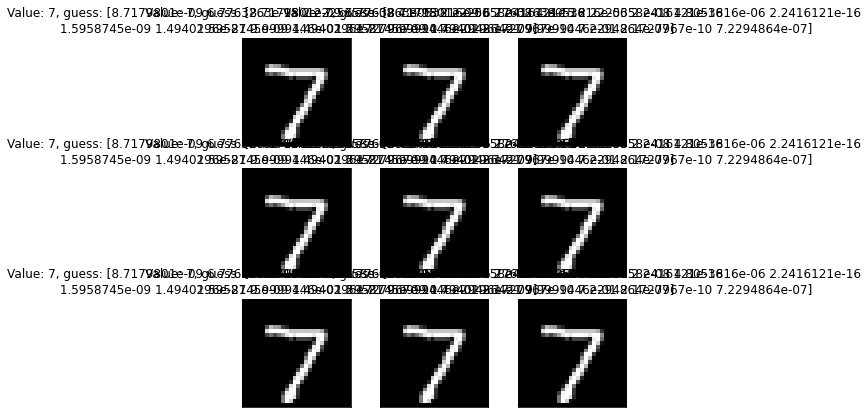

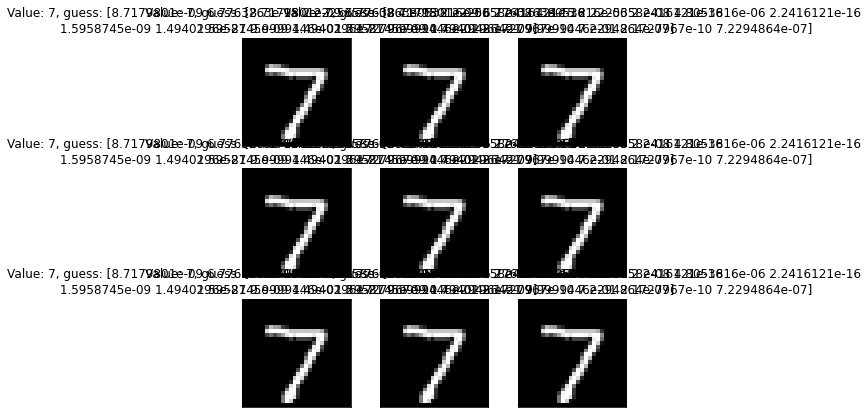

time: 837 ms (started: 2022-11-07 03:50:22 +00:00)


In [25]:
plt.rcParams['figure.figsize'] = (7,14)
figure_evaluation = plt.figure()

for i, incor in enumerate(incorrect[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(test_X[incor].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Value: {}, guess: {}".format(testy[incor], pred7[incor]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation